# **Introduction**

### **Pre-Training SomBERTa for Language Modeling**

In this notebook, we focus on the pre-training of **SomBERTa**, a BERT-based language model tailored for the Somali language. Pre-training a language model on a specific language enables better performance on downstream tasks, such as sentiment analysis, text classification, and named entity recognition. This approach aligns with recent advancements in natural language processing, where language-specific models are pre-trained on vast corpora to capture unique linguistic characteristics.

The notebook is organized into the following sections:
1. **Setup and Data Loading**: We start by loading the required libraries and mounting Google Drive for data access.
2. **Data Preprocessing**: Text data is prepared for training, including tokenization and cleaning.
3. **Model Configuration and Training**: We configure and initiate the SomBERTa model, followed by training it on the preprocessed dataset.
4. **Evaluation**: Finally, we evaluate the pre-trained model to assess its performance.

By the end of this notebook, we aim to have a pre-trained SomBERTa model that can be fine-tuned for various NLP tasks in Somali. Let's dive in!

# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Required Libraries**

In [ ]:
import pandas as pd
import os
import csv
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

# **Datasets**

In [ ]:
path = "/content/drive/MyDrive/Final/" # change this with data folder.

# Load the tsv datasets into DataFrames
df1_mas, df2_bbc, df3_afr, df4_som, df5_bks = [pd.read_csv(f'{path}/{file}', sep='\t')
                 for file in [
                     'MasakaNews.tsv',
                      'BBC Somali.tsv',
                      'SomAfriBERTa.tsv',
                      'CC100-Somali.tsv',
                      'Somali Books.tsv']]

df6_HF1 = pd.read_csv(f"{path}/CIRAL-Somali.csv")

In [ ]:
df1_mas.head() # sample data frame.

,title,text,url
0,Mareykanka dad ka badan 40 qof oo tahriibayaal...,Ugu yaraan 46 qof oo la rumeysan yahay in ay ...,https://www.bbc.com/somali/war-61962361
1,Warar sheegaya in la sii daayay badmaaxayaashi...,Toban badmaax oo u dhashay dalka Turkiga oo bi...,https://www.bbc.com/somali/war-49303460
2,Doorashada Mareykanka 2020: Dadka Mareykanka o...,Donald Trump ayaa muddo isbuucyo ah sheegayay ...,https://www.bbc.com/somali/war-54813950
3,Shan arrimood oo ku saabsan isticmaalka khudra...,Beytaraafka waa khudrad muhiim ah oo ka qeyb q...,https://www.bbc.com/somali/61371455
4,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,Waxyaabaha ay dadku sida aadka ah u xiiseeyaan...,https://www.bbc.com/somali/war-60298334


### **Data Inspection**

In [ ]:
def display_dataframe_info(dfs):
    """
    Displays the info of each DataFrame in the given list.

    Parameters:
    dfs (list): A list of DataFrames.
    """
    for i, df in enumerate(dfs, start=1):
        print(f"DataFrame {i}:")
        print(df.info())
        print(f"Number of rows: {len(df)}")
        print(f"Number of columns: {len(df.columns)}")
        print("---")

In [ ]:
# Display the info of each DataFrame
dataframes = [df1_mas, df2_bbc, df3_afr, df4_som, df5_bks, df6_HF1]
display_dataframe_info(dataframes)

DataFrame 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1463 non-null   object
 1   text    1463 non-null   object
 2   url     1463 non-null   object
dtypes: object(3)
memory usage: 34.4+ KB
None
Number of rows: 1463
Number of columns: 3
---
DataFrame 2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7540 entries, 0 to 7539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   7489 non-null   object
 1   text    7540 non-null   object
 2   url     7540 non-null   object
dtypes: object(3)
memory usage: 176.8+ KB
None
Number of rows: 7540
Number of columns: 3
---
DataFrame 3:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1 non-null      obj

# **Data Preprocessing**

In [ ]:
# let us check the duplicated rows in any df.
def check_duplicates(dataframes, df_names):
    result = []

    for i, df in enumerate(dataframes):
        # Count duplicated rows
        duplicate_count = df.duplicated().sum()
        result.append({
            'DataFrame': df_names[i],
            'Total Rows': len(df),
            'Duplicated Rows': duplicate_count
        })

    # Create a summary DataFrame
    summary_df = pd.DataFrame(result)
    return summary_df

In [ ]:
dataframes = [df1_mas, df2_bbc, df3_afr, df4_som, df5_bks,df6_HF1]
df_names = ['MasakaNews', 'BBC', 'SomAfriBERTa', 'CC100-Somali', 'Somali Books','Hugginface Dataset']

duplicate_summary = check_duplicates(dataframes, df_names)

# Display the result
duplicate_summary

,DataFrame,Total Rows,Duplicated Rows
0,MasakaNews,1463,0
1,BBC,7540,6280
2,SomAfriBERTa,1,0
3,CC100-Somali,1,0
4,Somali Books,75,0
5,Hugginface Dataset,503000,148


We have only two data frames with duplicated rows, so let us deduplicate them.

In [ ]:
# let us deduplicate the dfs.
def remove_duplicates(dataframes, df_names):

    cleaned_dataframes = {}

    for i, df in enumerate(dataframes):
        # Remove duplicated rows
        cleaned_df = df.drop_duplicates().reset_index(drop=True)
        cleaned_dataframes[df_names[i]] = cleaned_df

    return cleaned_dataframes


In [ ]:
dataframes = [df1_mas, df2_bbc, df3_afr, df4_som, df5_bks,df6_HF1]
df_names = ['MasakaNews', 'BBC', 'SomAfriBERTa', 'CC100-Somali', 'Somali Books','Hugginface Dataset']

# Call the function to remove duplicates
cleaned_dataframes = remove_duplicates(dataframes, df_names)

# You can access each cleaned dataframe by name, for example:
df1 = cleaned_dataframes['MasakaNews']
df2 = cleaned_dataframes['BBC']
df3 = cleaned_dataframes['SomAfriBERTa']
df4 = cleaned_dataframes['CC100-Somali']
df5 = cleaned_dataframes['Somali Books']
df6 = cleaned_dataframes['Hugginface Dataset']

In [ ]:
# let us check again...
dataframes = [df1, df2, df3, df4, df5, df6]
duplicate_summary = check_duplicates(dataframes, df_names)

# Display the result
duplicate_summary

,DataFrame,Total Rows,Duplicated Rows
0,MasakaNews,1463,0
1,BBC,1260,0
2,SomAfriBERTa,1,0
3,CC100-Somali,1,0
4,Somali Books,75,0
5,Hugginface Dataset,502852,0


### `Preprocessor`

In [ ]:
import re
import unicodedata

# Somali alphabet
SOMALI_ALPHABET = (
    "aA" "bB" "cC" "dD" "eE" "fF" "gG" "hH" "iI" "jJ" "kK" "lL" "mM" "nN"
    "oO" "qQ" "rR" "sS" "tT" "uU" "wW" "xX" "yY"
)

ALLOWED_CHARS = SOMALI_ALPHABET + "0123456789 ,.!?()-'" # Numbers and standard punctuation

def preprocessor(text):
    text = unicodedata.normalize("NFKD", text) # Normalize text to NFKD form to handle accented characters and other unicode variations
    text = ''.join([char for char in text if not unicodedata.combining(char)]) # Remove diacritics (accents) while keeping Somali alphabet characters
    text = text.lower() # Lowercase the text (BERT often use lowercase pretraining)
    text = ''.join([char for char in text if char in ALLOWED_CHARS.lower()]) # Remove unwanted characters based on ALLOWED_CHARS
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with a single space
    return text

In [ ]:
df1.head()

,title,text,url
0,Mareykanka dad ka badan 40 qof oo tahriibayaal...,Ugu yaraan 46 qof oo la rumeysan yahay in ay ...,https://www.bbc.com/somali/war-61962361
1,Warar sheegaya in la sii daayay badmaaxayaashi...,Toban badmaax oo u dhashay dalka Turkiga oo bi...,https://www.bbc.com/somali/war-49303460
2,Doorashada Mareykanka 2020: Dadka Mareykanka o...,Donald Trump ayaa muddo isbuucyo ah sheegayay ...,https://www.bbc.com/somali/war-54813950
3,Shan arrimood oo ku saabsan isticmaalka khudra...,Beytaraafka waa khudrad muhiim ah oo ka qeyb q...,https://www.bbc.com/somali/61371455
4,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,Waxyaabaha ay dadku sida aadka ah u xiiseeyaan...,https://www.bbc.com/somali/war-60298334


### Before cleaning the text

In [ ]:
## Let us combine the title and the text into a text field
def concat_title_text(dataframes, title_col="title", text_col="text"):
    """
    Concatenates the 'title' and 'text' columns for each DataFrame in the list.
    The new column 'text' will store the concatenated result.
    """
    for df in dataframes:
        if title_col in df.columns and text_col in df.columns:
            df["text"] = df[title_col] + " " + df[text_col]
    return dataframes

# Concatenate the 'title' and 'text' columns for each DataFrame
dataframes = concat_title_text(dataframes)
df1.head()

,title,text,url
0,Mareykanka dad ka badan 40 qof oo tahriibayaal...,Mareykanka dad ka badan 40 qof oo tahriibayaal...,https://www.bbc.com/somali/war-61962361
1,Warar sheegaya in la sii daayay badmaaxayaashi...,Warar sheegaya in la sii daayay badmaaxayaashi...,https://www.bbc.com/somali/war-49303460
2,Doorashada Mareykanka 2020: Dadka Mareykanka o...,Doorashada Mareykanka 2020: Dadka Mareykanka o...,https://www.bbc.com/somali/war-54813950
3,Shan arrimood oo ku saabsan isticmaalka khudra...,Shan arrimood oo ku saabsan isticmaalka khudra...,https://www.bbc.com/somali/61371455
4,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,https://www.bbc.com/somali/war-60298334


In [ ]:
def drop_columns(dataframes, col_names):
  for i, df in enumerate(dataframes):
    # Drop the 'title' and 'url' columns and then store the updated df back into the list (dataframes)
    dataframes[i] = df.drop(columns=col_names, errors='ignore')

In [ ]:
drop_columns(dataframes, ['title', 'url'])

In [ ]:
# updating dataframes
df1, df2, df3, df4, df5, df6 = dataframes[:6]

In [ ]:
df1.columns

Index(['text'], dtype='object')

In [ ]:
df1.text[3] # a sample record of text from MasakhaNews dataset for Somali.

'Shan arrimood oo ku saabsan isticmaalka khudradda Beytaraafka Beytaraafka waa khudrad muhiim ah oo ka qeyb qaadata xoojinta caafimaadka qofka isla markaana horseeda in qofka isticmaala aanu daalin marka uu sameynayo jimicsiga. Sidoo kale Beytaraafka wuxuu hoos u dhigaa cadaadiska dhiigga iyo ilaalinta caafimaadka maskaxda. Waxaana beytaraafka la adeegsan jiray tan iyo xilliggii Giriiggii hore, Sidaa darteed waxaa la ogaaday waxtarka uu u leeyahay aadanaha. Waxaa soo ifbaxaya caddeymaha ku saabsan faa\'idooyinka aan caadiga aheyn ee beytaraafka iyo sababta aan ugu darsanno cuntadeena. Midabka dabiiciga ah ee madow ee beytaraafka, waxaa loo yaqaan betalains, wuxuuna leeyahay awood xoog leh. Dhowr sano ka hor, cilmi-baaris uu Talyaaniga ku sameeyay beytaraafka ayaa muujisay in uu dili karo kansarka ku dhaca unugyada mindhicirka. Awoodda uu leeyahay beytaraafka waxaa kamid ah inuu ku badan yahay maadada Nitrate. Ma wanaagsano isticmaalka badan ee maadada Nitrate tusaale ahaan haddii maada

---

## **Corpus Statistics Before Cleansing**

In [ ]:
import pandas as pd
from IPython.display import display

def analyze_text_data(dataframes, names):
    results = []

    total_articles = 0
    total_sentences = 0
    total_tokens = 0

    for df, name in zip(dataframes, names):
        # number of srticles
        num_articles = len(df)

        # number of sentences
        num_sentences = round(df['text'].str.count(r'[.!?]').sum())

        # number of words (Tokens)
        words_count = len(' '.join(df['text'].astype(str)).split())

        # let us update totals
        total_articles += num_articles
        total_sentences += num_sentences
        total_tokens += words_count

        results.append({
            "DataFrame": name,
            "# Articles": num_articles,
            "# Sents": num_sentences,
            "# Tokens": words_count
        })

    # a total row for all columns
    results.append({
        "DataFrame": "Total",
        "# Articles": total_articles,
        "# Sents": total_sentences,
        "# Tokens": total_tokens
    })

    return pd.DataFrame(results)

In [ ]:
# Function to compute unique words from a given DataFrame
def count_words(df):
    df['corpus'] = df['text'].fillna('').astype(str)
    df['tokens'] = df['corpus'].apply(lambda x: x.split())
    unique_words = [word for tokens in df['tokens'] for word in tokens]
    unique_word_count = len(unique_words)
    return unique_word_count

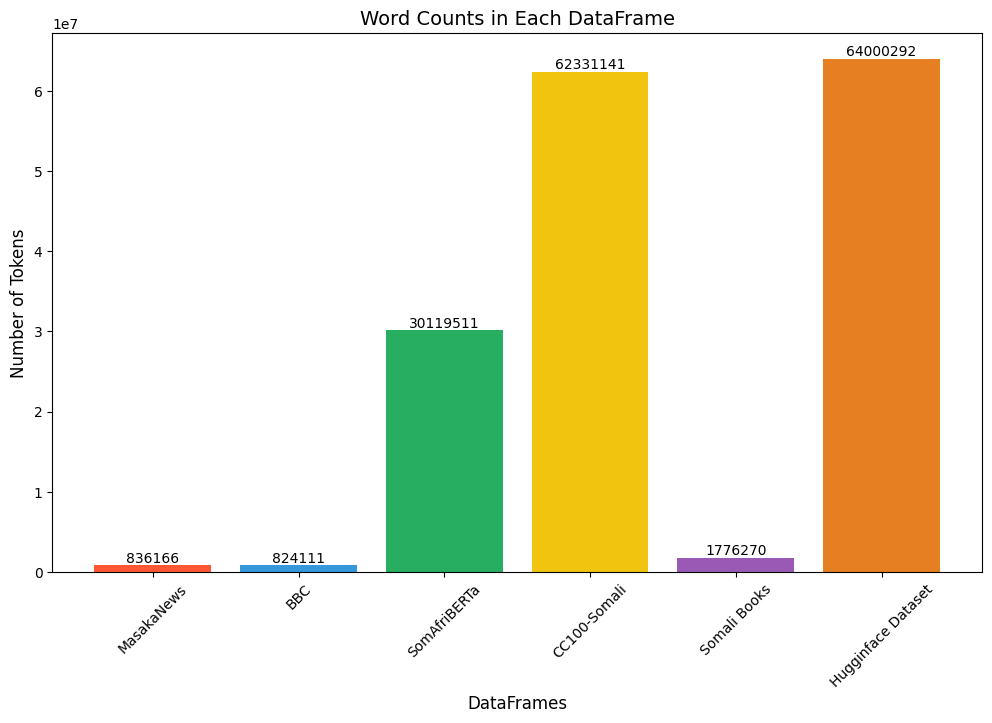

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate unique word count for each dataframe
unique_word_counts = [count_words(df) for df in dataframes]


# Define a color gradient from red (smallest) to green (largest)
color_gradient = ['#D70000', '#FF4500', '#008000', '#FFD700', '#32CD32', '#FFA500']

solid_colors = ['#FF5733',  # Strong Red-Orange
              '#3498DB',  # Bold Blue
              '#27AE60',  # Deep Green
              '#F1C40F',  # Bright Yellow-Gold
              '#9B59B6',  # Rich Purple
              '#E67E22']  # Dark Orange


# Plotting the results using a vertical bar plot
plt.figure(figsize=(12, 7))
bars = plt.bar(df_names, unique_word_counts, color=solid_colors)
# Add count values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('DataFrames', fontsize=12)
plt.ylabel('Number of Tokens', fontsize=12)
plt.title('Word Counts in Each DataFrame', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()


In [ ]:
df_analysis = analyze_text_data(dataframes, df_names)
display(df_analysis)


,DataFrame,# Articles,# Sents,# Tokens
0,MasakaNews,1463,35902,836166
1,BBC,1260,32826,824122
2,SomAfriBERTa,1,955114,30119511
3,CC100-Somali,1,2399311,62331141
4,Somali Books,75,136984,1776270
5,Hugginface Dataset,502852,2549809,64000292
6,Total,505652,6109946,159887502


In [ ]:
df2.head()

,text,corpus,tokens
0,Booliiska Soomaaliya oo BBC da u sheegay halka...,Booliiska Soomaaliya oo BBC da u sheegay halka...,"[Booliiska, Soomaaliya, oo, BBC, da, u, sheega..."
1,Maxay cuntada Soomaalidu caan uga dhex noqoney...,Maxay cuntada Soomaalidu caan uga dhex noqoney...,"[Maxay, cuntada, Soomaalidu, caan, uga, dhex, ..."
2,Waa maxay cudurka busbuska ee faraha ba'an ku ...,Waa maxay cudurka busbuska ee faraha ba'an ku ...,"[Waa, maxay, cudurka, busbuska, ee, faraha, ba..."
3,Lix sababood oo ka danbeeyay dhimashadii tirad...,Lix sababood oo ka danbeeyay dhimashadii tirad...,"[Lix, sababood, oo, ka, danbeeyay, dhimashadii..."
4,"Sheekada Fakhra Axmed, gabadha 15-ka sano ...","Sheekada Fakhra Axmed, gabadha 15-ka sano ...","[Sheekada, Fakhra, Axmed,, gabadha, 15-ka, san..."


---

## **Corpus Statistics After Cleansing**

### Cleaning the text field.

In [ ]:
# Function to clean and preprocess a DataFrame
def clean_dataframe(df):
    # Drop duplicate rows based on the 'text' column
    df.drop_duplicates(subset='text', keep='first', inplace=True)

    # Apply preprocessing function to the 'text' column
    df['text'] = df['text'].fillna('').apply(preprocessor)

    return df

# apply the cleaning function to each dataframe
for i, df in enumerate(dataframes):
    dataframes[i] = clean_dataframe(df)
    print(f" {df_names[i]} has been cleaned")

 MasakaNews has been cleaned
 BBC has been cleaned
 SomAfriBERTa has been cleaned
 CC100-Somali has been cleaned
 Somali Books has been cleaned
 Hugginface Dataset has been cleaned


This cleaning process has taken over 5ms.


In [ ]:
df1.text[3] # df1.text[3] # a sample record of text from MasakhaNews dataset for Somali.

"shan arrimood oo ku saabsan isticmaalka khudradda beytaraafka beytaraafka waa khudrad muhiim ah oo ka qeyb qaadata xoojinta caafimaadka qofka isla markaana horseeda in qofka isticmaala aanu daalin marka uu sameynayo jimicsiga. sidoo kale beytaraafka wuxuu hoos u dhigaa cadaadiska dhiigga iyo ilaalinta caafimaadka maskaxda. waxaana beytaraafka la adeegsan jiray tan iyo xilliggii giriiggii hore, sidaa darteed waxaa la ogaaday waxtarka uu u leeyahay aadanaha. waxaa soo ifbaxaya caddeymaha ku saabsan faa'idooyinka aan caadiga aheyn ee beytaraafka iyo sababta aan ugu darsanno cuntadeena. midabka dabiiciga ah ee madow ee beytaraafka, waxaa loo yaqaan betalains, wuxuuna leeyahay awood xoog leh. dhowr sano ka hor, cilmi-baaris uu talyaaniga ku sameeyay beytaraafka ayaa muujisay in uu dili karo kansarka ku dhaca unugyada mindhicirka. awoodda uu leeyahay beytaraafka waxaa kamid ah inuu ku badan yahay maadada nitrate. ma wanaagsano isticmaalka badan ee maadada nitrate tusaale ahaan haddii maadad

From that sample data, we can see that the text has been cleaned. Therefore, let do some exploratory data analysis (EDA) from this point forward.


Each data frame has 3 columns, which are title, text, and url. Hense, before concatenating all dataframes, let us drop the title and url columns, then draw the unique words in the text field for each data frame.

In [ ]:
def display_columns(dfs):
  for i, df in enumerate(dataframes):
    print(dataframes[i].columns)

In [ ]:
display_columns(dataframes)

Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')


In [ ]:
df1.head()

,text,corpus,tokens
0,mareykanka dad ka badan 40 qof oo tahriibayaal...,Mareykanka dad ka badan 40 qof oo tahriibayaal...,"[Mareykanka, dad, ka, badan, 40, qof, oo, tahr..."
1,warar sheegaya in la sii daayay badmaaxayaashi...,Warar sheegaya in la sii daayay badmaaxayaashi...,"[Warar, sheegaya, in, la, sii, daayay, badmaax..."
2,doorashada mareykanka 2020 dadka mareykanka oo...,Doorashada Mareykanka 2020: Dadka Mareykanka o...,"[Doorashada, Mareykanka, 2020:, Dadka, Mareyka..."
3,shan arrimood oo ku saabsan isticmaalka khudra...,Shan arrimood oo ku saabsan isticmaalka khudra...,"[Shan, arrimood, oo, ku, saabsan, isticmaalka,..."
4,waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,"[Waxyaabaha, u, gaarka, ah, gawaarida, qaybta,..."


### Exploring the unique words in the dfs

In [ ]:
# Function to compute unique words from a given DataFrame
def count_words(df):
    df['corpus'] = df['text'].fillna('').astype(str)
    df['tokens'] = df['corpus'].apply(lambda x: x.split())
    unique_words = [word for tokens in df['tokens'] for word in tokens]
    unique_word_count = len(set(unique_words))
    return unique_word_count

In [ ]:
df_names = ['MasakaNews', 'BBC Somali', 'SomAfriBERTa', 'CC100-Somali', 'Somali Books','CIRAL-Somali']

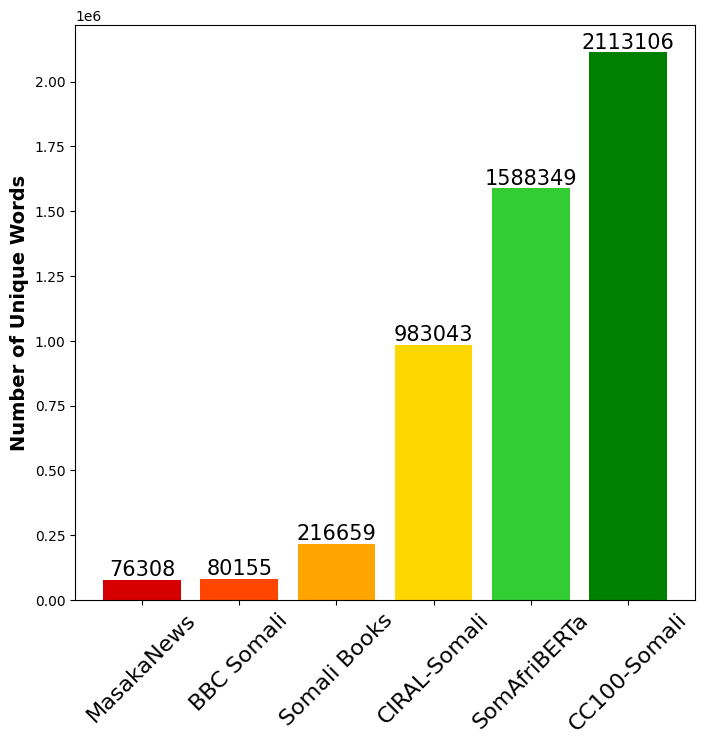

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate unique word count for each dataframe
unique_word_counts = [count_words(df) for df in dataframes]

# Sort data by unique word count (smallest to largest)
sorted_indices = np.argsort(unique_word_counts)
df_names_sorted = [df_names[i] for i in sorted_indices]
unique_word_counts_sorted = [unique_word_counts[i] for i in sorted_indices]

# Define a color gradient from red (smallest) to green (largest)
color_gradient = ['#D70000',  # Dark Red (smallest)
                  '#FF4500',  # Orange-Red
                  '#FFA500',  # Orange
                  '#FFD700',  # Gold
                  '#32CD32',  # Lime Green
                  '#008000']  # Dark Green (largest)

# Plotting the results using a vertical bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(df_names_sorted, unique_word_counts_sorted, color=color_gradient)

# Add count values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', fontsize=15,fontweight='normal')

# Adding labels and title
# plt.xlabel('DataFrames', fontsize=12)
plt.ylabel('Number of Unique Words', fontsize=14, fontweight='semibold')
# plt.title('Unique Word Count in Each DataFrame (Sorted by Size)', fontsize=14)
plt.xticks(rotation=45, fontsize=16, fontweight='normal')  # Rotate x-axis labels for readability
# Add extra padding around plot
plt.subplots_adjust(bottom=0.25, top=1.4)  # More space for x-labels and top number
# Show the plot
plt.show()


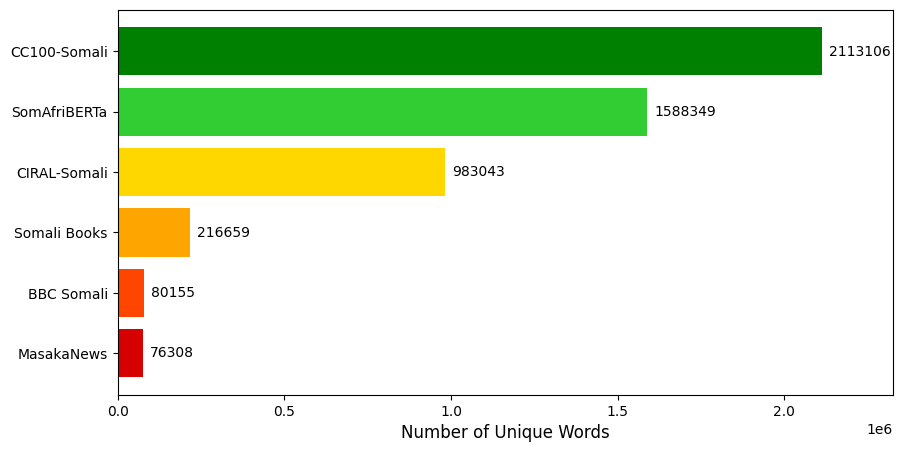

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate unique word count for each dataframe
unique_word_counts = [count_words(df) for df in dataframes]

# Sort data by unique word count (smallest to largest)
sorted_indices = np.argsort(unique_word_counts)
df_names_sorted = [df_names[i] for i in sorted_indices]
unique_word_counts_sorted = [unique_word_counts[i] for i in sorted_indices]

# Define a color gradient from red (smallest) to green (largest)
color_gradient = ['#D70000',  # Dark Red (smallest)
                  '#FF4500',  # Orange-Red
                  '#FFA500',  # Orange
                  '#FFD700',  # Gold
                  '#32CD32',  # Lime Green
                  '#008000']  # Dark Green (largest)

# Set figure size
plt.figure(figsize=(10, 5))

# Create horizontal bar plot
bars = plt.barh(df_names_sorted, unique_word_counts_sorted, color=color_gradient)

# Add count values next to each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + (0.01 * max(unique_word_counts_sorted)),  # Shift slightly to the right
             bar.get_y() + bar.get_height()/2,
             round(xval),
             ha='left', va='center', fontsize=10)

# Adjust x-axis limits to fit all labels properly
plt.xlim(0, max(unique_word_counts_sorted) * 1.1)  # Add 10% margin for visibility

# Adding labels and title
# plt.ylabel('DataFrames', fontsize=12)
plt.xlabel('Number of Unique Words', fontsize=12)
# plt.title('Unique Word Count in Each DataFrame (Sorted by Size)', fontsize=14)

# Show the plot
plt.show()

In [ ]:
df_analysis = analyze_text_data(dataframes, df_names)
display(df_analysis)

,DataFrame,# Articles,# Sents,# Tokens
0,MasakaNews,1463,36001,835863
1,BBC,1250,32970,823513
2,SomAfriBERTa,1,1017769,28982783
3,CC100-Somali,1,2660585,60347349
4,Somali Books,75,144985,1750369
5,Hugginface Dataset,494962,2644353,63213926
6,Total,497752,6536663,155953803


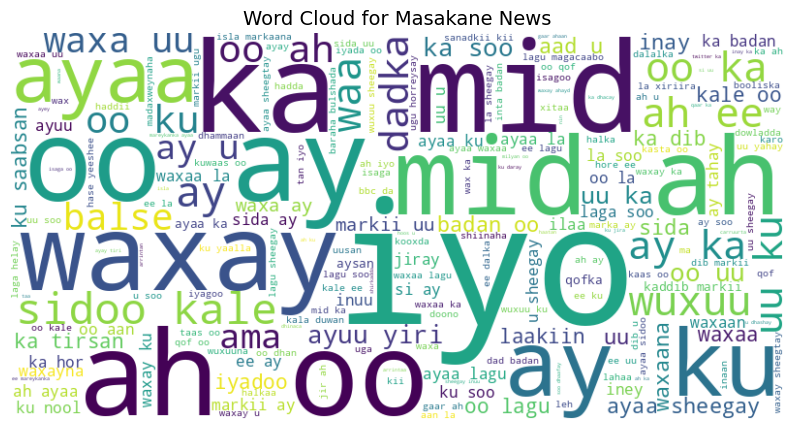

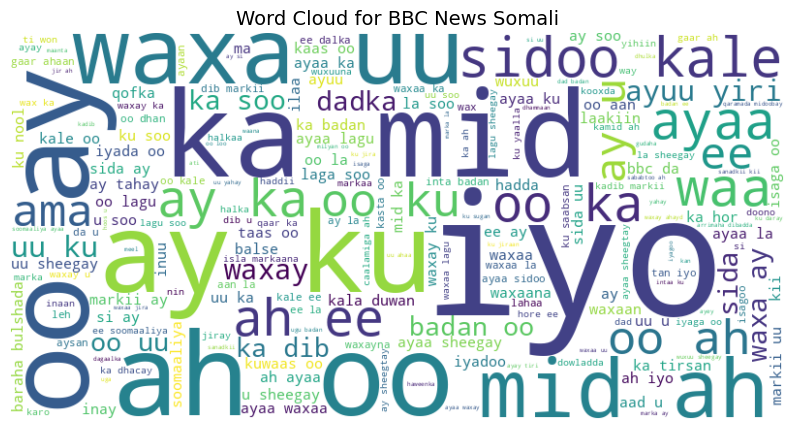

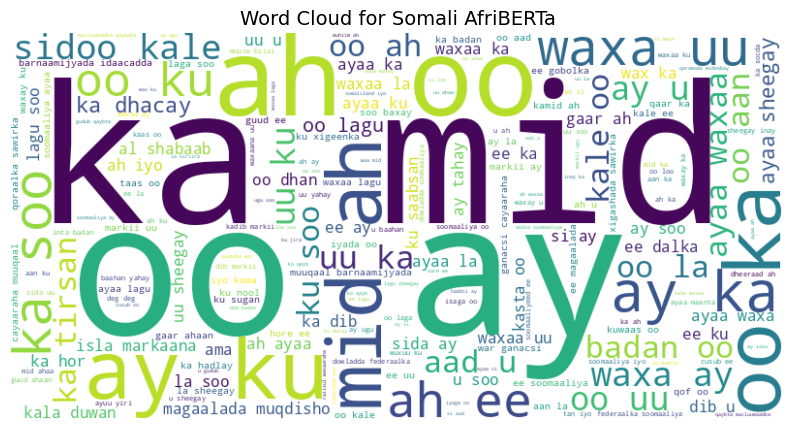

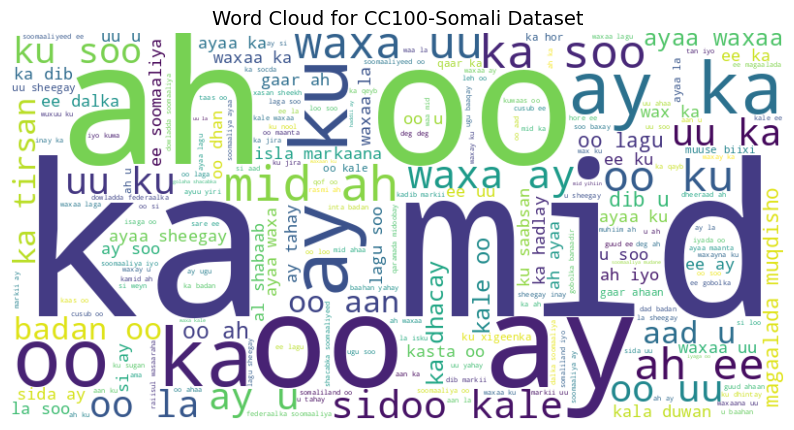

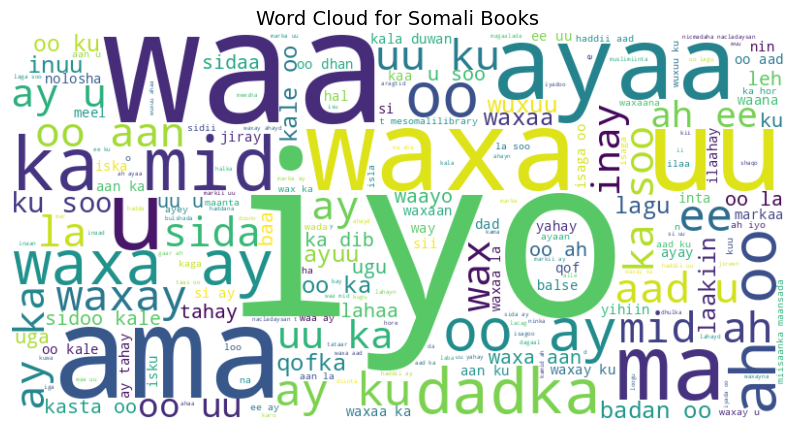

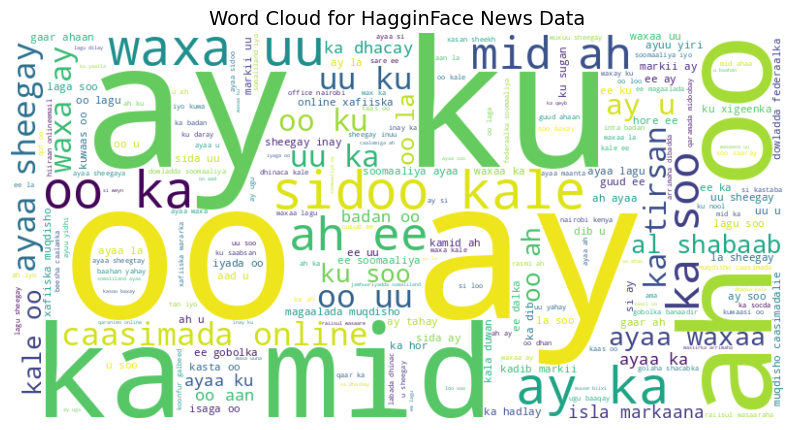

In [ ]:
# !pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_clouds(dataframes, df_names):
    # Iterate over each dataframe
    for i, df in enumerate(dataframes):
        # Combine all text from the 'text' column into one large string
        text_data = ' '.join(df['text'].astype(str))

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

        # Plot the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Turn off axis labels
        plt.title(f'Word Cloud for {df_names[i]}', fontsize=14)

        # Show the plot
        plt.show()

# Generate word clouds for all the dataframes
generate_word_clouds(dataframes, df_names)


Since we are going to build a pre-trained model, we are not worrying about the stopwords in the texts.

In [ ]:
display_columns(dataframes)

Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')
Index(['text', 'corpus', 'tokens'], dtype='object')


In [ ]:
drop_columns(dataframes, ['corpus', 'tokens'])

Now, let us concatenate all dataframes except Masakane News data, which we are going to evaluate the model later on, and start the training process for the model.

In [ ]:
df = pd.concat(dataframes[1:], ignore_index=True)
df.head()

,text
0,faisa iyo cabaas waa labo lammaane ah oo dayar...
1,kacdoonka casriga ah ee baraha bulshadu waxuu ...
2,nooc cusub oo fayraska busbuska ayaa si degdeg...
3,gudashada waajibkaadka xajka ayaa sanad walba ...
4,fauia aim tahir ayaa bbc-da kala hadlaysay gab...


In the following subsequent steps of the stage (EDA), we will find out the sentences and unique tokens, but first let us see the unique chars in the text field.

In [ ]:
def explore_chars(field):
  # Concatenate all comments into a single text string
  text = " ".join(field.astype(str))
  # Analyze the length of the concatenated text
  text_length = len(text)
  print(f"Length of the concatenated text: {text_length}")
  # Identify unique characters in the text
  unique_chars = sorted(set(text))
  print("Unique characters in the text: \n[")
  for i in range(0, len(unique_chars), 30):
      print("".join(repr(char) for char in unique_chars[i:i+30]))
  print(']')
  # Count the number of unique characters
  unique_char_count = len(unique_chars)
  print(f"Number of unique characters: {unique_char_count}")

In [ ]:
explore_chars(df.text)

Length of the concatenated text: 987171501
Unique characters in the text: 
[
' ''!'"'"'('')'',''-''.''0''1''2''3''4''5''6''7''8''9''?''a''b''c''d''e''f''g''h''i''j''k'
'l''m''n''o''q''r''s''t''u''w''x''y'
]
Number of unique characters: 42


### Exploring the number of sentences and unique tokens for the training corpus

In [ ]:
# Function to handle sentence tokenization while accounting for hyphens and apostrophes
def split_sentences(text):
    # Regular expression that splits only on sentence-ending punctuation
    sentence_boundary_pattern = r'(?<!\w[.!?])(?<!\w[\w\'-])[.!?](?!\w)'
    sentences = re.split(sentence_boundary_pattern, text)
    # Filter out any empty strings from the result
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

# Function to compute number of sentences and unique words from the DataFrame
def count_sentences_and_unique_words(df):
    # Step 1: Create a new column from the 'cleaned_text' field
    df['cleaned_text'] = df['text'].fillna('').astype(str)
    # Step 2: Count sentences using the custom split_sentences function
    df['sentences'] = df['cleaned_text'].apply(split_sentences)
    # Step 3: Use the count_unique_words function for counting unique words
    unique_word_count = count_unique_words(df)
    # Step 4: Calculate the number of sentences
    sentence_count = df['sentences'].apply(len).sum()  # Total number of sentences

    return sentence_count, unique_word_count

### For the Training Data

In [ ]:
# Apply the function on the concatenated DataFrame
sentence_count, unique_word_count = count_sentences_and_unique_words(df)
print(f"Total Sentences: {sentence_count}")
print(f"Total Unique Words: {unique_word_count}")

Total Sentences: 721647
Total Unique Words: 3490152


In the above output, we have **721,647** sentences and around **3.5 million** unique words to train our model.

### For the Evaluation Data

In [ ]:
sentence_count, unique_word_count = count_sentences_and_unique_words(df1_mas)
print(f"Total Sentences: {sentence_count}")
print(f"Total Unique Words: {unique_word_count}")

Total Sentences: 2037
Total Unique Words: 75580


Whereas, around **2k** sentences and **76k** unique words in the Masakane News data to evaluate our moudel.

Save the data with the text field only to easily load later.

In [ ]:
train = df[['text']]
train.head()

,text
0,faisa iyo cabaas waa labo lammaane ah oo dayar...
1,kacdoonka casriga ah ee baraha bulshadu waxuu ...
2,nooc cusub oo fayraska busbuska ayaa si degdeg...
3,gudashada waajibkaadka xajka ayaa sanad walba ...
4,fauia aim tahir ayaa bbc-da kala hadlaysay gab...


In [ ]:
eval = df1_mas[['text']]
eval.head()

,text
0,ugu yaraan 46 qof oo la rumeysan yahay in ay y...
1,toban badmaax oo u dhashay dalka turkiga oo bi...
2,donald trum ayaa muddo isbuucyo ah sheegayay i...
3,beytaraafka waa khudrad muhiim ah oo ka qeyb q...
4,waxyaabaha ay dadku sida aadka ah u xiiseeyaan...


### Let us save the preprocessed data to our local disk or Google Drive

In [ ]:
# saving text data
train.to_csv('/content/drive/MyDrive/AA_V2/som_data/train.tsv', sep='\t', index=False)
eval.to_csv('/content/drive/MyDrive/AA_V2/som_data/eval.tsv', sep='\t', index=False)

___

# **Training Steps**

## **Step 1: Train a Custom Tokenizer Using Hugging Face Tokenizers**
Now, let’s train a WordPiece tokenizer using the train and eval data

In [ ]:
train_texts, eval_texts = train['text'].tolist(), eval['text'].tolist()

In [ ]:
from tokenizers import BertWordPieceTokenizer

# Initialize the WordPiece tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

# Save the cleaned text to a file that the tokenizer can read from
cleaned_texts = train_texts + eval_texts
file_path = "/content/drive/MyDrive/AA_V2/SOMALI_CORPUS.txt"
with open(file_path, "w", encoding="utf-8") as f:
    for text in cleaned_texts:
        f.write(f"{text}\n")

# Train the tokenizer on the cleaned Somali text data
tokenizer.train(
    files=[file_path],
    vocab_size=70000,
    min_frequency=2,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

The tokenizer has been trained in 4m 3s.

#### Saving the tokenizer

In [ ]:
import os

dir = '/content/drive/MyDrive/AA_V2/tokenizer/somberta_tokenizer_70k'

# if os.path.exists(dir):
#   print(f'{dir} folder already exists')
  # !rm -rf ./dir
os.makedirs(dir, exist_ok=True)

# Save the tokenizer to a directory
tokenizer.save_model(dir)

['/content/drive/MyDrive/AA_V2/tokenizer/somberta_tokenizer_70k/vocab.txt']

## **Step 2: Generating and Tokenizing MLM Samples for BERT Pretraining**

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer

# We don't need sentence pairs for MLM, so we can work with single sentences
def get_mlm_samples(texts):
    # Simply return the texts as individual samples for MLM
    return texts

# MLM does not require positive/negative samples, so just get all texts
train_samples = get_mlm_samples(train_texts)
eval_samples = get_mlm_samples(eval_texts)

# The masking function for MLM
def mask_tokens(inputs, tokenizer, mask_prob=0.15):
    labels = inputs.clone()

    # Create a probability matrix for masking
    probability_matrix = torch.full(labels.shape, mask_prob)

    # Avoid masking special tokens
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]

    # Zero out the probability of masking special tokens
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

    # Generate random masking according to the probability matrix
    masked_indices = torch.bernoulli(probability_matrix).bool()

    # Replace masked tokens with the mask token id
    inputs[masked_indices] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    return inputs, labels

# Tokenize and apply masking to each sample for MLM
def tokenize_samples_with_mlm(samples, tokenizer):
    tokenized_samples = []
    for sentence in samples:
        input_ids = tokenizer.encode(sentence, add_special_tokens=True)
        input_ids = torch.tensor([input_ids])

        # Apply masking to the input tokens
        masked_input, labels = mask_tokens(input_ids, tokenizer)

        tokenized_samples.append({
            'input_ids': masked_input.squeeze(0),
            'labels': labels.squeeze(0)
        })
    return tokenized_samples

# Load the custom tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(dir)

# Process the training and evaluation data for MLM
train_tokenized_samples = tokenize_samples_with_mlm(train_samples, bert_tokenizer)
eval_tokenized_samples = tokenize_samples_with_mlm(eval_samples, bert_tokenizer)


This took  52m 43s to run.

### Saving and loading the tokenized samples

In [ ]:
%%time
import torch
import os

# Define the paths where you want to save the data on Google Drive
path = '/content/drive/MyDrive/AA_V2/tokenized_samples/'
os.makedirs(path, exist_ok=True)  # Create the directory if it doesn't exist

# Save train_tokenized_samples
torch.save(train_tokenized_samples, os.path.join(path, 'somberta_70k_train_tokenized_samples.pt'))

# Save eval_tokenized_samples
torch.save(eval_tokenized_samples, os.path.join(path, 'somberta_70k_eval_tokenized_samples.pt'))

print("Tokenized samples saved successfully.")


Tokenized samples saved successfully.
CPU times: user 49.5 s, sys: 8.7 s, total: 58.2 s
Wall time: 1min 31s


---

## **Step 3: Chaninging the Runtime to GPU**

#### **Importing the Tokenizer**

In [ ]:
# Load the custom tokenizer using BertTokenizer from Hugging Face
from transformers import BertTokenizer
import os

dir = '/content/drive/MyDrive/AA_V2/tokenizer/somberta_tokenizer_70k'

# Load the custom tokenizer
tokenizer = BertTokenizer.from_pretrained(dir)

# Test the tokenizer
print(tokenizer.tokenize("Hadalkaan waa maxay sababta ka danbeeysa?"))

['hadalkaan', 'waa', 'maxay', 'sababta', 'ka', 'danbeeysa', '?']


#### **Load the Training Data to Dest the Tokenizer**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AA_V2/som_data/train.tsv', sep='\t')

In [ ]:
print(tokenizer.tokenize(df.text[3]))

['gudashada', 'waajibka', '##adka', 'xajka', 'ayaa', 'sanad', 'walba', 'waxaa', 'dalka', 'sacuudiga', 'u', 'taga', 'xuj', '##ay', 'aad', 'u', 'tiro', 'badan', 'oo', 'ka', 'kala', 'imaanaya', 'wadamada', 'caalamka', '.', 'waxaa', 'marka', 'la', 'eego', 'tirooyinka', 'ay', 'soo', 'gudbiyeen', 'ilaa', 'toban', 'wadan', 'iyo', 'diblumaasiyiin', 'ku', 'howlan', 'baadigoobka', 'dhibanayaasha', 'xajka', ',', 'tirada', 'dhimashadu', 'gaarsiisan', 'tahay', '1', ',', '09', '##6', 'xaaji', ',', 'iyadoo', 'sababa', 'inta', 'badan', 'aan', 'la', 'cayimin', ',', 'sida', 'ay', 'sheegtay', 'wakaalada', 'wararka', 'af', '.', 'bbc', '-', 'du', 'way', 'awoodi', 'wayday', 'inay', 'si', 'madaxbanaan', 'u', 'xaqiijiso', 'tirada', 'dhimashada', 'xujeyda', 'sanadkan', '.', 'waxaan', 'isku', 'daynay', 'inaan', 'la', 'xiriirno', 'masuuliyiinta', 'sacuudiga', 'labo', 'jeer', 'markii', 'koowaad', '19', '-', 'kii', 'juun', ',', 'iyo', 'marlabaad', 'oo', 'ah', '20', '-', 'kii', 'june', ',', 'si', 'aan', 'uga', 'faa

### **Imprting the tokenized samples**

In [ ]:
%%time
import torch
import os
path = '/content/drive/MyDrive/AA_V2/tokenized_samples/'

# Load train_tokenized_samples
train_tokenized_samples = torch.load(os.path.join(path, 'somberta_70k_train_tokenized_samples.pt'))

# # Load eval_tokenized_samples
eval_tokenized_samples = torch.load(os.path.join(path, 'somberta_70k_eval_tokenized_samples.pt'))

print("Tokenized samples loaded successfully.")


Tokenized samples loaded successfully.
CPU times: user 43.9 s, sys: 4.73 s, total: 48.7 s
Wall time: 1min 3s


## **Step 4: Custom Dataset for BERT Pretraining: Masked Language Modeling (MLM)**

We will apply random masking for MLM during the pre-training process.

In [ ]:
# We will apply random masking for MLM during the pre-training process.
from torch.utils.data import Dataset
import torch

class BERTPretrainingDataset(Dataset):
    def __init__(self, tokenized_samples, max_len=512):
        self.samples = tokenized_samples
        self.max_len = max_len

    def pad_and_truncate(self, input_ids, labels):
        # Truncate to the maximum length
        input_ids = input_ids[:self.max_len]
        labels = labels[:self.max_len]

        # Pad if necessary
        padding_length = self.max_len - len(input_ids)
        input_ids += [0] * padding_length  # Pad input ids with 0 (padding token)
        labels += [-100] * padding_length  # Pad labels with -100 (ignored in MLM loss)

        return input_ids, labels

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # We're now dealing with a single sequence, not concatenated sentences
        input_ids = sample['input_ids'].tolist()
        mlm_labels = sample['labels'].tolist()

        # Pad and truncate as needed
        input_ids, mlm_labels = self.pad_and_truncate(input_ids, mlm_labels)

        # Create the attention mask (1 for real tokens, 0 for padding tokens)
        attention_mask = [1] * len(input_ids)

        # Since we're not using sentence pairs, all token_type_ids can be 0
        token_type_ids = [0] * self.max_len

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),  # All 0s for single sentence tasks
            'labels': torch.tensor(mlm_labels, dtype=torch.long)  # MLM labels (with -100 for ignored positions)
        }

    def __len__(self):
        return len(self.samples)

train_data = BERTPretrainingDataset(train_tokenized_samples)
eval_data = BERTPretrainingDataset(eval_tokenized_samples)

___

## **Step 5: Model Configurations**

In [ ]:
from transformers import BertConfig, BertForMaskedLM, Trainer, TrainingArguments

# Define the model configuration (same as before)
from transformers import BertConfig, BertForMaskedLM

# Define the model configuration (same as before)
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=10,
    num_attention_heads=6,
    intermediate_size=3072,
    max_position_embeddings=512,
    type_vocab_size=1,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

In [ ]:
# Initialize the MLM-only model
model = BertForMaskedLM(config=config)

# Check number of parameters
model.num_parameters()
# => 125+ million parameters

125696368

In [ ]:
tokenizer.vocab_size

70000

We have 125+ Million Params for the model being trianed

## **Step 6: Setup for Training Arguments**

In [ ]:
# Training arguments for GPU
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/AA_V2/training_args_70k',
    # overwrite_output_dir=False,
    ignore_data_skip=False,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    per_device_train_batch_size=40,
    per_device_eval_batch_size=40,
    save_steps=10_000,
    warmup_steps=1000,
    save_total_limit=10,
    learning_rate=3e-4,
    dataloader_num_workers=6,
    eval_strategy="steps",
    eval_steps=1000,
    prediction_loss_only=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer
)

## **Step 7: Training the Model**

In [ ]:
# Clear GPU cache before training
%%time
import torch
torch.cuda.empty_cache()

# Train the model
trainer.train()

Step,Training Loss,Validation Loss
1000,1.138800,1.163551
2000,1.050000,1.107085
3000,0.683100,0.906426
4000,0.577400,0.851562
5000,0.529400,0.819593


Step,Training Loss,Validation Loss
1000,1.138800,1.163551
2000,1.050000,1.107085
3000,0.683100,0.906426
4000,0.577400,0.851562
5000,0.529400,0.819593
6000,0.499600,0.790592
7000,0.449900,0.773174
8000,0.435800,0.759113
9000,0.425400,0.751590


CPU times: user 9h 54min 24s, sys: 48.7 s, total: 9h 55min 13s
Wall time: 9h 52min 35s


TrainOutput(global_step=9045, training_loss=0.7799060796228412, metrics={'train_runtime': 35553.7406, 'train_samples_per_second': 40.703, 'train_steps_per_second': 0.254, 'total_flos': 3.180478516233339e+17, 'train_loss': 0.7799060796228412, 'epoch': 3.0})

## **Step 8: Model Evaluation**

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
eval_results

{'eval_loss': 0.7515276074409485,
 'eval_runtime': 12.1872,
 'eval_samples_per_second': 120.044,
 'eval_steps_per_second': 3.036,
 'epoch': 3.0}

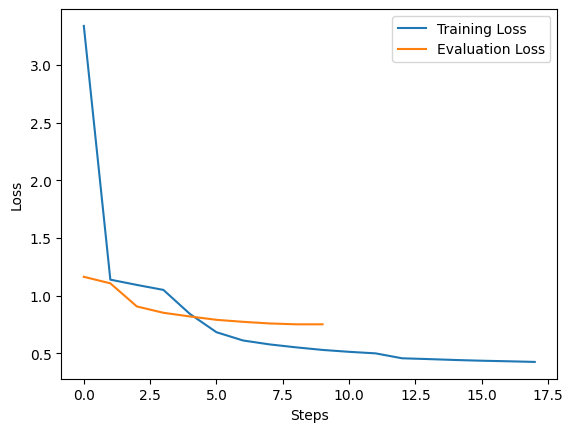

In [ ]:
import matplotlib.pyplot as plt

# Extract training and evaluation loss
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plot the loss curves
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


### **Model Training and Evaluation Interpretation**

The model training process is summarized in the table and the loss plot. Key observations include the steady decline in both **training loss** and **evaluation loss** over time, as well as the overall performance trends, which are outlined below.

#### Training and Validation Loss Summary
- The training started with a high initial training loss of approximately **1.14** and validation loss of **1.16** at step 1000.
- As training progressed, both training and validation losses showed a steady decline, indicating that the model was learning effectively and generalizing reasonably well.
- By step 9000, the training loss decreased to approximately **0.43**, while the validation loss reached **0.75**. The reduction in loss suggests that the model converged effectively, achieving a stable state with minimal overfitting, as reflected by the relatively close values of training and validation loss.

#### Loss Curve Analysis
The loss curve plot shows the trajectories of both **training loss** and **evaluation loss** over the training steps:
- **Training Loss** (blue line): The training loss exhibits a sharp decrease at the beginning, rapidly dropping from around 3.5 to below 1.0 within the first few thousand steps. This indicates that the model quickly adapted to the patterns in the training data.
- **Evaluation Loss** (orange line): The evaluation loss also shows a consistent downward trend, although it remains slightly higher than the training loss, which is typical. This gap suggests the model maintains good generalization while not overfitting to the training data.

#### Overall Performance and Model Convergence
- The steady convergence of both training and validation losses by the end of training indicates that the model learned the task well and has reached a stable solution.
- The **final training loss** is around **0.425**, and the **final validation loss** is around **0.751**. The modest gap between these values suggests that the model is well-tuned for generalization on the validation set, demonstrating good performance on unseen data.

#### Key Takeaways
- The model effectively minimized both training and evaluation losses, showing that it successfully learned the task.
- The closeness of the final training and validation losses indicates that the model is not overfitting.
- This model is likely well-prepared for downstream evaluation on test data, and further fine-tuning could refine performance if needed.

This analysis shows that the model's training was successful, achieving a balance between learning the training data and generalizing to validation data. The results suggest that this model is ready for further testing or deployment.


## **Step 9: Save the Model**

In [ ]:
# Save the pre-trained SomBERTa model
model.save_pretrained('/content/drive/MyDrive/AA/SomeBERTaModel/SomBERTa-large')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k')

('/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k/tokenizer_config.json',
 '/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k/special_tokens_map.json',
 '/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k/vocab.txt',
 '/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k/added_tokens.json')

In [ ]:
from transformers import BertForMaskedLM, BertTokenizer

# Load the pre-trained model
model = BertForMaskedLM.from_pretrained('/content/drive/MyDrive/AA/SomeBERTaModel/SomBERTa-large')

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k')


___